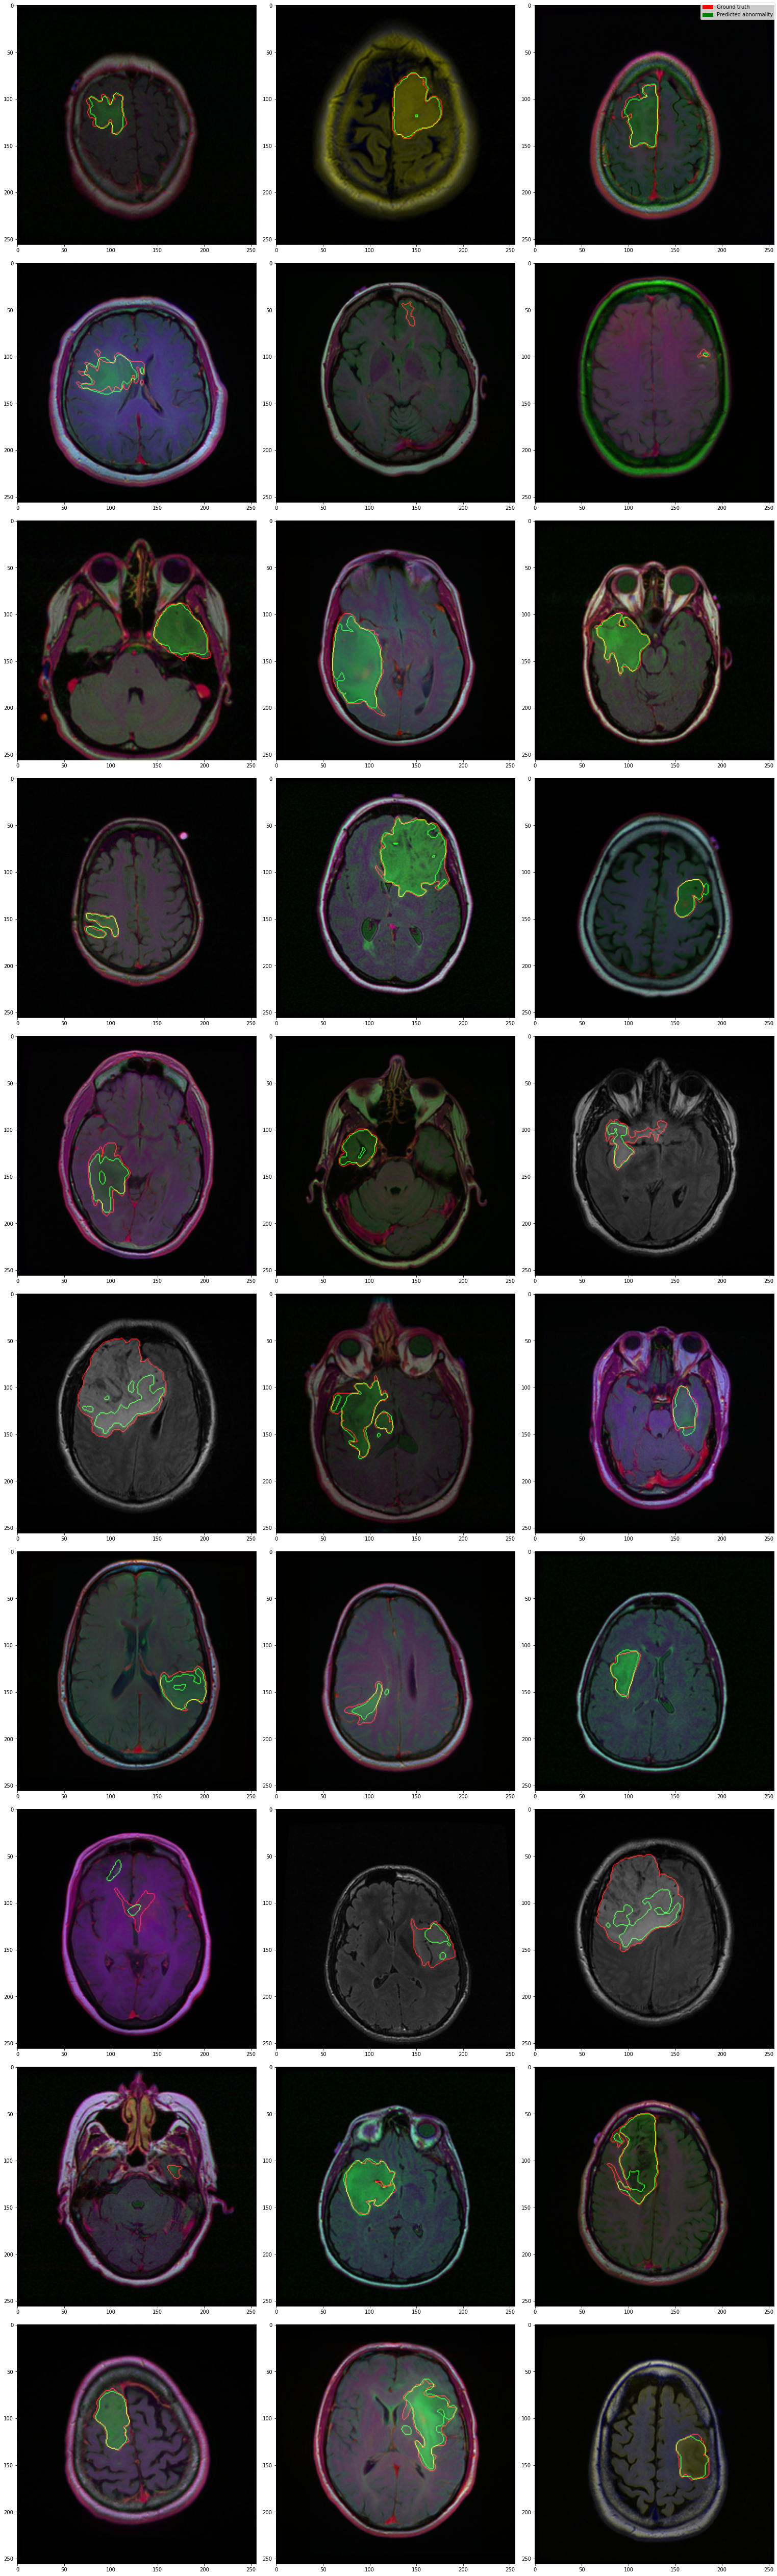

In [1]:
from glob import glob
from datasets.dataset_synapse import MriDataset
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.morphology import binary_dilation
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from data_frame_utils import get_file_row

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = 'kaggle_3m/data.csv'
files_dir = 'kaggle_3m/'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')
df = pd.read_csv(csv_path)
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
df = pd.merge(df, filenames_df, on="Patient")

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(test_df, test_size=0.5, random_state=42)

valid_dataset = MriDataset(valid_df)
test_dataset = MriDataset(test_df)

batch_size = 8
img_size = 256

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)
config_vit = CONFIGS_ViT_seg["R50-ViT-B_16"]
config_vit.n_classes = 1
config_vit.n_skip = 3

model = ViT_seg(config_vit, img_size=img_size, num_classes=config_vit.n_classes).cuda()
model.load_state_dict(torch.load("weights.pt"))


width = 3
columns = 10
n_examples = columns * width

fig, axs = plt.subplots(columns, width, figsize=(7*width , 7*columns), constrained_layout=True)
red_patch = mpatches.Patch(color='red', label='The red data')
fig.legend(loc='upper right',handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')])
    
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0]
        if not mask.byte().any():
            continue
        image = image.to(device)
        prediction = model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        prediction_edges = prediction - binary_dilation(prediction)
        ground_truth = mask - binary_dilation(mask)
        image[0, 0, ground_truth.bool()] = 1
        image[0, 1, prediction_edges.bool()] = 1
        
        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        if n_examples == i + 1:
            break
        i += 1